# CCN Classifier trained with CIFAR-10

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

# PyTorch dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Use GPU if Available
print("Using GPU: ", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using GPU:  True


In [3]:
# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

In [4]:
# Data transform to convert data to a tensor and apply normalization
# augment train and validation dataset with RandomHorizontalFlip and RandomRotation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [5]:
# choose the training and test datasets
train_data = datasets.CIFAR10('../Pytorch_Data/CIFAR_data/', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10('../Pytorch_Data/CIFAR_data/', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [7]:
# define samplers for obtaining training and validation batches
# Samples elements randomly from a given list of indices, without replacement.
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [8]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [9]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Visualize the training data

In [10]:
# helper function to un-normalize an image
def unnormalize(img):
    img = img / 2 + 0.5  # unnormalize
    return np.transpose(img.squeeze(), (1, 2, 0))  # convert from Tensor image

In [11]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
images.shape

(20, 3, 32, 32)

The sample image is:



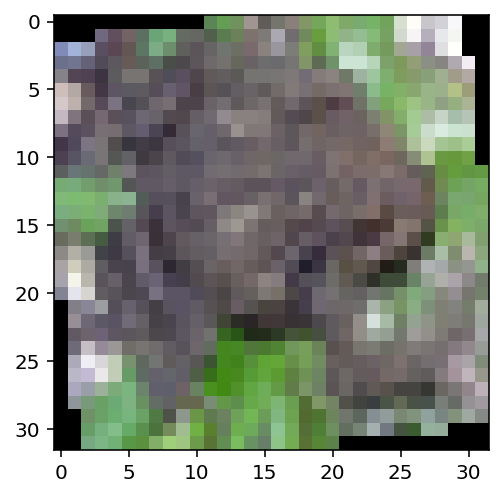

The label is:  frog


In [13]:
print("The sample image is:\n")
img = np.random.randint(len(images), size=1)
# print(images[img].squeeze().shape)
plt.imshow(unnormalize(images[img]), cmap='binary')
plt.show()
print("The label is: ", classes[labels[img]])

In [14]:
def display_images_from_data(train_data, test_data, rows = 3, cols = 4, figsize_x = 15, figsize_y = 10):
    rand_data_vector = np.random.randint(0, len(train_data), rows * cols)
    subplot_counter = 1
    plt.figure(figsize=(figsize_x, figsize_y))
    plt.suptitle('Images from train data', fontsize=20)
    for row in range(rows):
        for col in range(cols):
            plt.subplot(rows, cols, subplot_counter)
            plt.imshow(unnormalize(train_data[rand_data_vector[row+col]]))
            plt.title('Label: ' + classes[test_data[rand_data_vector[row+col]]])
            plt.axis('off')
            subplot_counter += 1
    plt.show()

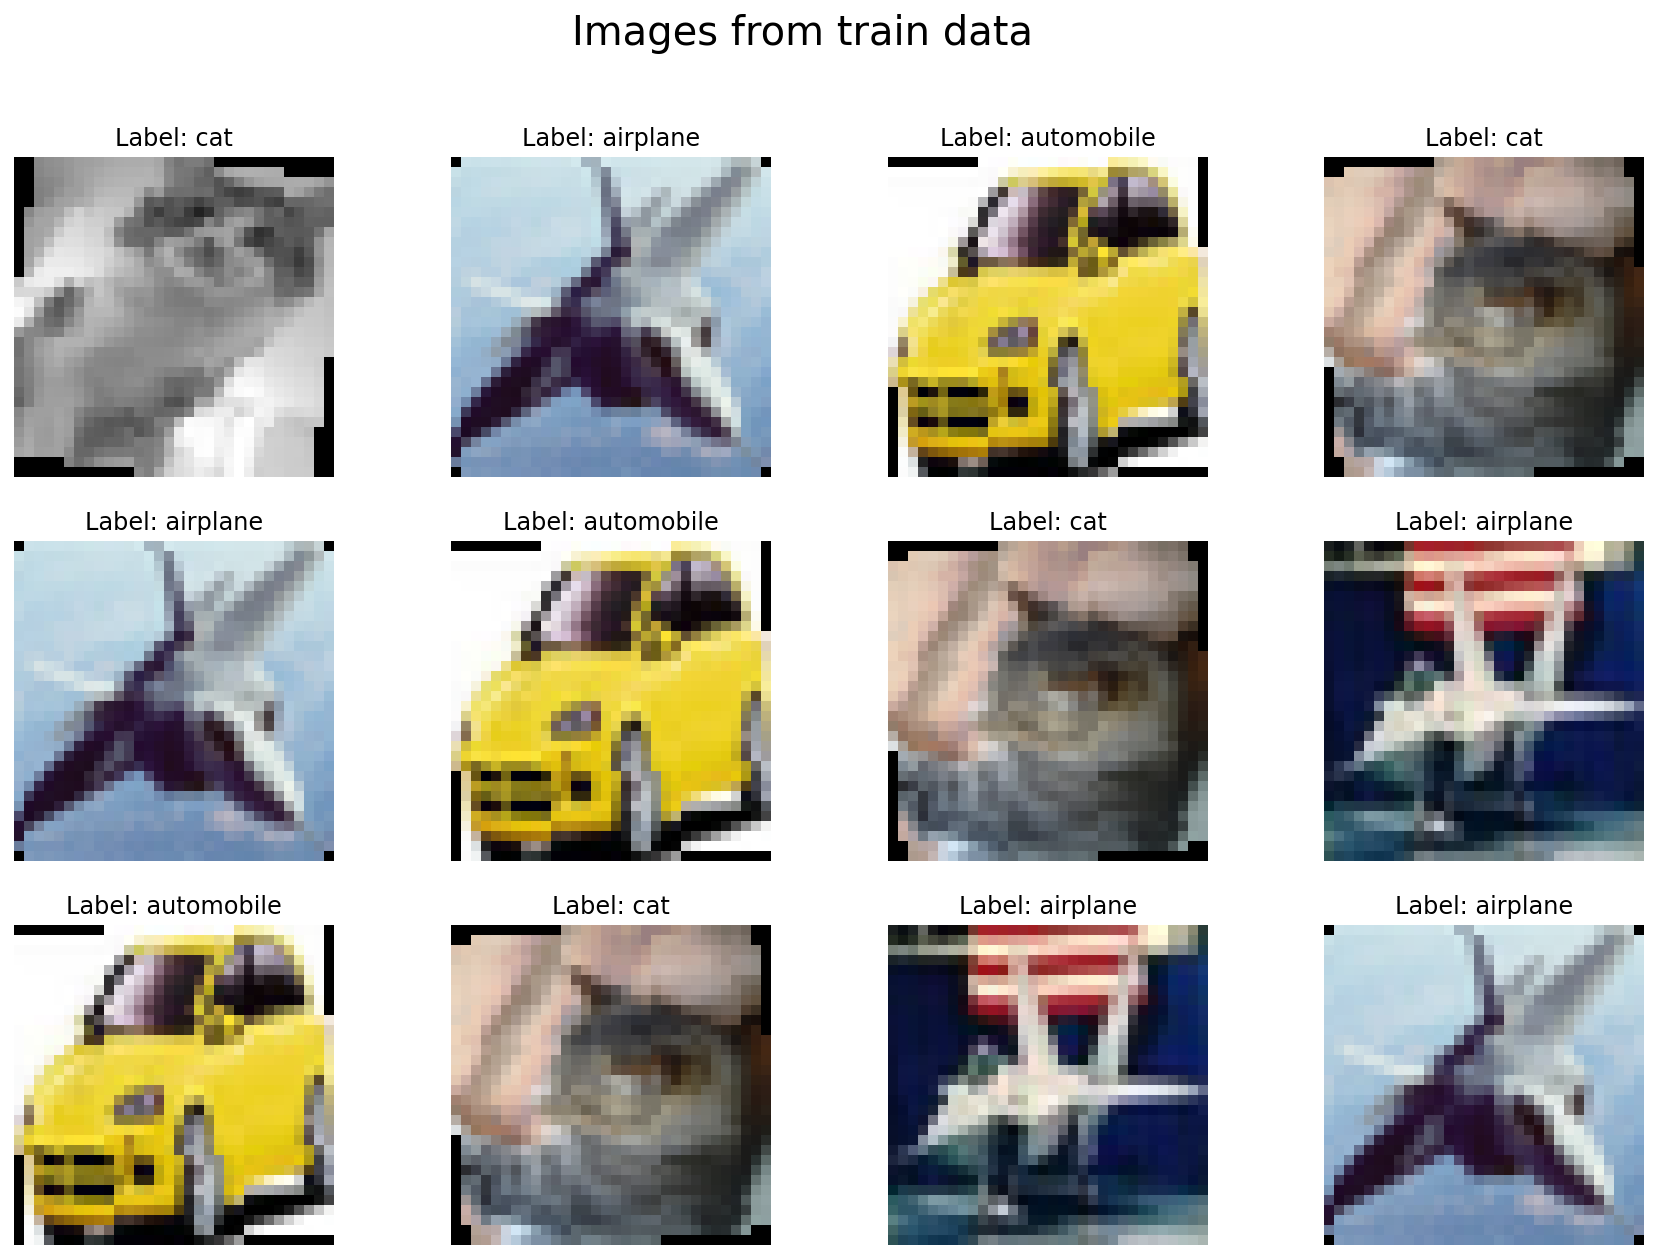

In [15]:
display_images_from_data(images, labels)

### Model definition

In [20]:
class Net(nn.Module):
    '''
    This class is used to create a neural network.
    It is composed of a series of convolutional layers, a series of linear layers
    '''
    def __init__(self, input_size_lin, color_img = True, output_size = 10, hidden_layers = [128], hidden_conv_layers = [16, 32, 64], padding = 1, kernel_size = 3,  drop_p=0.25):
        '''
        This function is used to initialize the class.
        It takes the following arguments:
        - input_size_lin: the size of the input vector that enter to the classifier (number of features)
        - color_img: a boolean indicating if the input image is color or grayscale
        - output_size: the number of classes
        - hidden_layers: the number of neurons in each hidden layer of the classifier
        - hidden_conv_layers: the number of neurons in each hidden convolutional layer (the features extractor)
        - padding: the padding of the convolutional layers
        - kernel_size: the kernel size of the convolutional layers
        - drop_p: the probability of dropping a neuron in the dropout layer
        
        The function returns:
        - None
        
        The function does:
        - Initializes the class
        - Initializes the convolutional layers
        - Initializes the linear layers (classifier)
        
        The function calls:
        - super().__init__()
        - nn.Conv2d()
        - nn.Linear()
        - nn.MaxPool2d()
        - nn.Dropout()
        '''
        super(Net, self).__init__()

        # Definition of the convolutional layers
        in_channels = 3 if color_img else 1
        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels, hidden_conv_layers[0], kernel_size=kernel_size, padding=padding)])
        conv_layer_sizes = zip(hidden_conv_layers[:-1], hidden_conv_layers[1:])
        self.conv_layers.extend([nn.Conv2d(h1, h2, kernel_size=kernel_size, padding=padding) for h1, h2 in conv_layer_sizes])

        # definition of the linear layers (classifier)
        self.input_size_lin  = input_size_lin
        self.lin_layers = nn.ModuleList([nn.Linear(self.input_size_lin, hidden_layers[0])])
        Lin_hidden_layers = zip(hidden_layers[:-1], hidden_layers[1:])
        self.lin_layers.extend([nn.Linear(h1, h2) for h1, h2 in Lin_hidden_layers])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer (p=drop_p)
        self.dropout = nn.Dropout(drop_p)

    def forward(self, x):
        """
        This function is used to define the forward pass of the neural network.
        It takes the following arguments:
        - x: the input vector
        
        The function returns:
        - x: the output vector
        
        The function does:
        - Defines the forward pass of the neural network
        """

        for each in  self.conv_layers:
            x = F.relu(each(x))
            x = self.pool(x)

        x = x.view(-1, self.input_size_lin)

        for each in self.lin_layers[:-1]:
            x = F.relu(each(x))
            x = self.dropout(x)
        
        x = F.relu(self.lin_layers[-1](x))
        return x

In [21]:
model = Net(1024, hidden_layers = [512, 256, 128], drop_p = 0.25)
model

Net(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [22]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Definition of the training loop

In [23]:
model.to(device)
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), './save/model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.261180 	Validation Loss: 1.908402
Validation loss decreased (inf --> 1.908402).  Saving model ...
Epoch: 2 	Training Loss: 1.764554 	Validation Loss: 1.650241
Validation loss decreased (1.908402 --> 1.650241).  Saving model ...
Epoch: 3 	Training Loss: 1.605148 	Validation Loss: 1.563381
Validation loss decreased (1.650241 --> 1.563381).  Saving model ...
Epoch: 4 	Training Loss: 1.502242 	Validation Loss: 1.455809
Validation loss decreased (1.563381 --> 1.455809).  Saving model ...
Epoch: 5 	Training Loss: 1.433784 	Validation Loss: 1.491349
Epoch: 6 	Training Loss: 1.377700 	Validation Loss: 1.377624
Validation loss decreased (1.455809 --> 1.377624).  Saving model ...
Epoch: 7 	Training Loss: 1.342314 	Validation Loss: 1.362057
Validation loss decreased (1.377624 --> 1.362057).  Saving model ...
Epoch: 8 	Training Loss: 1.316264 	Validation Loss: 1.326024
Validation loss decreased (1.362057 --> 1.326024).  Saving model ...
Epoch: 9 	Training Loss: 1.283328 

In [25]:
# Load the model with the lowest validation loss
model.load_state_dict(torch.load('./save/model_cifar.pt'))

<All keys matched successfully>

In [26]:
# track test loss
test_loss = 0.0
class_correct = list(0. for _ in range(10))
class_total = list(0. for _ in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.709270

Test Accuracy of airplane: 80% (807/1000)
Test Accuracy of automobile: 88% (882/1000)
Test Accuracy of  bird: 64% (648/1000)
Test Accuracy of   cat: 54% (541/1000)
Test Accuracy of  deer: 66% (663/1000)
Test Accuracy of   dog: 69% (691/1000)
Test Accuracy of  frog: 85% (853/1000)
Test Accuracy of horse: 84% (847/1000)
Test Accuracy of  ship: 87% (879/1000)
Test Accuracy of truck: 83% (832/1000)

Test Accuracy (Overall): 76% (7643/10000)


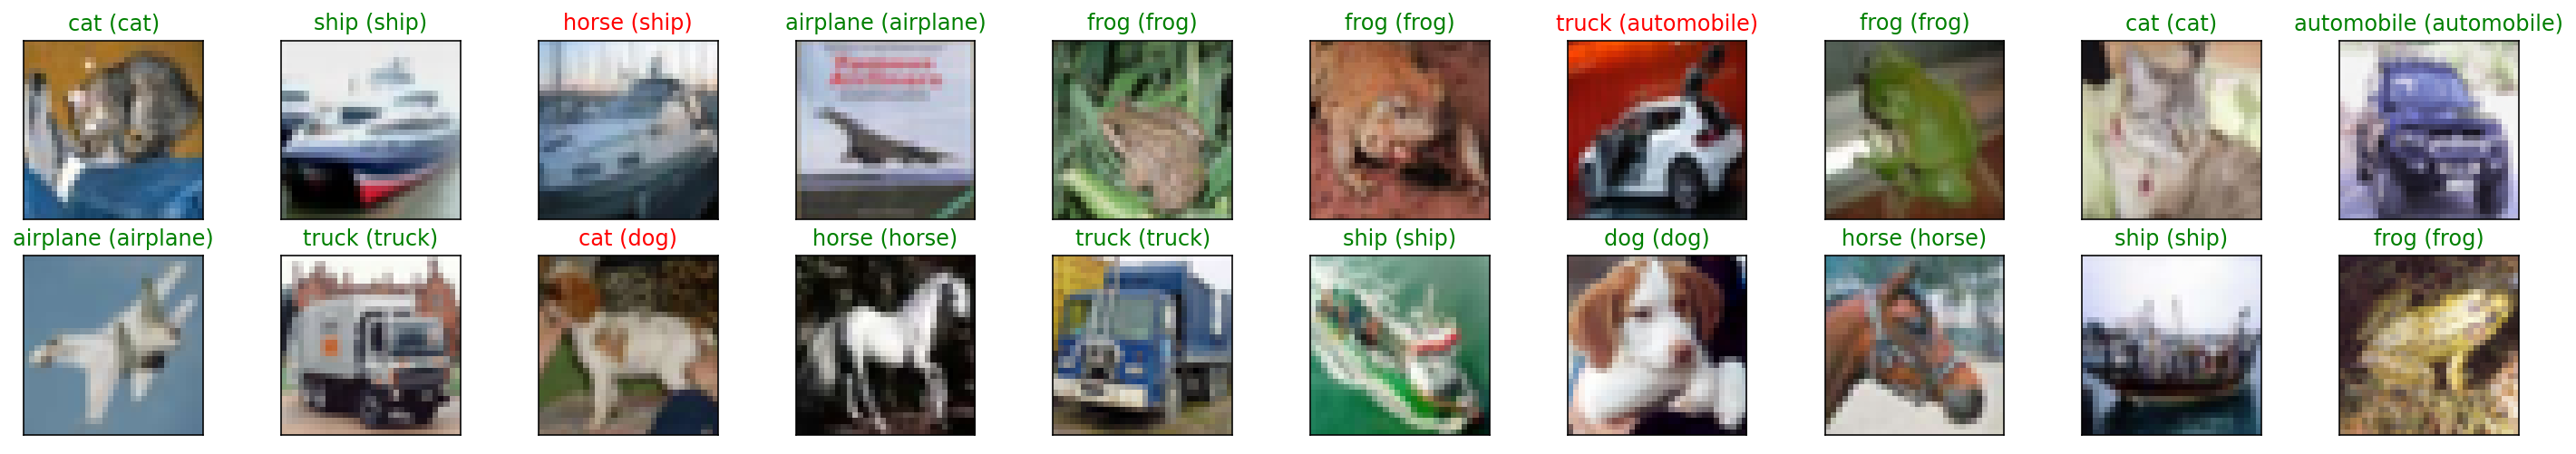

In [30]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(unnormalize(images[idx]) if not torch.cuda.is_available() else unnormalize(images[idx].cpu()))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))